In [16]:
import sympy as sp
sp.init_printing(long_frac_ratio=2)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("./mpl_style")
import matplotlib.patches as patches
from IPython.display import display

from panel_label import add_panel_label


In [15]:
slowlabel = r"$\omega_s$"
alfvenlabel = r"$\omega_A$"
fastlabel = r"$\omega_f$"
thermallabel = r"$\omega_{th}$"

xlabel = "Re($\omega$)"
ylabel = "Im($\omega$)"

In [2]:
rho1, vx1, vy1, vz1, T1, Ax1, Ax2, Ax3 = sp.symbols(
  "rho_1, v_{x1}, v_{y1}, v_{z1}, T_1, A_{x1}, A_{x2}, A_{x3}"
)
rho0, T0, gamma = sp.symbols("rho_0, T_0, gamma")
gmone = sp.Symbol("(\gamma - 1)")
LT = sp.Symbol("\mathcal{L}_T")
Lrho = sp.Symbol(r"\mathcal{L}_\rho")
kappa_para, kappa_perp, k_para, k_perp = sp.symbols(
  "\kappa_\parallel, \kappa_\perp, k_\parallel, k_\perp"
)

In [3]:
kx, ky, kz = sp.symbols("k_x, k_y, k_z")
B0x, B0y, B0z = sp.symbols("B_{x0}, B_{y0}, B_{z0}")
kvec = sp.Matrix([kx, ky, kz])
B0vec = sp.Matrix([B0x, B0y, B0z])
A1vec = sp.Matrix([Ax1, Ax2, Ax3])
v1vec = sp.Matrix([vx1, vy1, vz1])

In [4]:
state_vector = (rho1, vx1, vy1, vz1, T1, Ax1, Ax2, Ax3)
def expand_and_collect(eq):
  eq = eq.expand()
  return eq.collect(state_vector)

In [5]:
# continuity equation
continuity = rho0 * kvec.dot(v1vec)
continuity = expand_and_collect(continuity)
display(continuity)

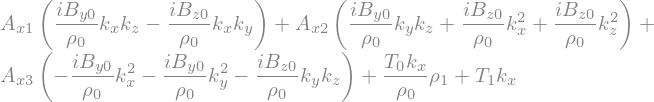

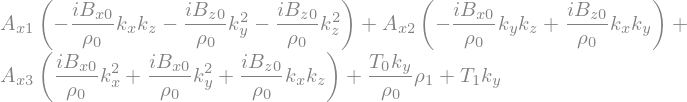

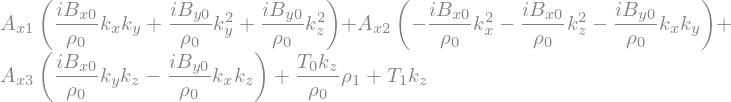

In [6]:
# momentum equation
mom = (
  T0 * kvec * rho1 
  + rho0 * kvec * T1 
  - sp.I * (kvec.cross(kvec.cross(A1vec)).cross(B0vec))
) / rho0

mom1 = expand_and_collect(mom[0])
mom2 = expand_and_collect(mom[1])
mom3 = expand_and_collect(mom[2])

display(mom1, mom2, mom3)


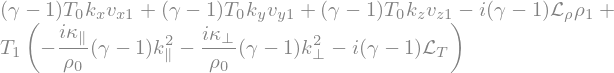

In [7]:
# energy equation
energy = (
  gmone * rho0 * T0 * kvec.dot(v1vec) 
  - sp.I * gmone * rho0 * (LT * T1 + Lrho * rho1)
  - sp.I * gmone * (kappa_para * k_para**2 + kappa_perp * k_perp**2) * T1
) / rho0
energy = expand_and_collect(energy)

display(energy)

In [8]:
# induction equation
induction = sp.I * v1vec.cross(B0vec)

induction1 = expand_and_collect(induction[0])
induction2 = expand_and_collect(induction[1])
induction3 = expand_and_collect(induction[2])

display(induction1, induction2, induction3)



### Simplification for wave solutions

In [9]:
b0 = sp.symbols("B_0")
substitutions = {B0x: 0, B0y: 0, B0z: b0, kx: k_perp, ky: 0, kz: k_para}
adiab_subs = {kappa_para: 0, kappa_perp: 0, LT: 0, Lrho: 0}

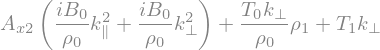

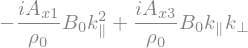

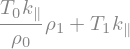

In [10]:
cont_simple = continuity.subs(substitutions)
mom1_simple = mom1.subs(substitutions)
mom2_simple = mom2.subs(substitutions)
mom3_simple = mom3.subs(substitutions)
energy_simple = energy.subs(substitutions).subs(adiab_subs)
induction1_simple = induction1.subs(substitutions)
induction2_simple = induction2.subs(substitutions)
induction3_simple = induction3.subs(substitutions)

display(cont_simple)
display(mom1_simple)
display(mom2_simple)
display(mom3_simple)
display(energy_simple)
display(induction1_simple)
display(induction2_simple)
display(induction3_simple)

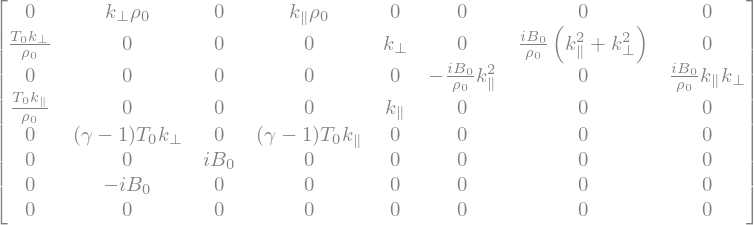

In [11]:
matrix = sp.Matrix([
  [0, k_perp * rho0, 0, k_para * rho0, 0, 0, 0, 0],
  [T0 * k_perp / rho0, 0, 0, 0, k_perp, 0, sp.I * b0 / rho0 * (k_para**2+k_perp**2), 0],
  [0, 0, 0, 0, 0, -sp.I * b0 * k_para**2 / rho0, 0, sp.I * b0 * k_para * k_perp / rho0],
  [T0 * k_para / rho0, 0, 0, 0, k_para, 0, 0, 0],
  [0, gmone * T0 * k_perp, 0, gmone * T0 * k_para, 0, 0, 0, 0],
  [0, 0, sp.I * b0, 0, 0, 0, 0, 0],
  [0, -sp.I * b0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0]
])
display(matrix)

In [12]:
def get_numerical_matrix(rho0val, T0val, b0val, k_perpval, k_paraval):
  numerical_matrix = sp.lambdify(
    (rho0, T0, b0, k_perp, k_para), 
    matrix.subs(gmone, 5/3 - 1),
    "numpy"
  )
  return numerical_matrix(rho0val, T0val, b0val, k_perpval, k_paraval)

In [13]:
eigvals = np.linalg.eigvals(
  get_numerical_matrix(rho0val=2, T0val=1, b0val=0.5, k_perpval=0.2, k_paraval=1)
)
eigvals = eigvals[abs(eigvals.real) > 1e-12]
for val in eigvals:
  print(val)

(1.3186055653794857+1.929879867024198e-17j)
(-1.3186055653794873-1.8973538018496328e-17j)
(0.3530052354903193+0j)
(-0.35300523549031915+0j)
(0.35355339059327384+0j)
(-0.35355339059327373+0j)


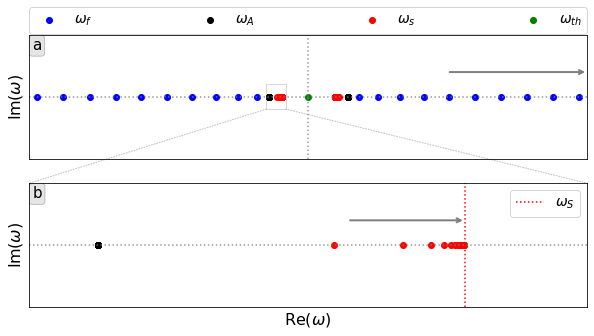

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

ax1, ax2 = axes
for ax in axes:
  ax.axhline(y=0, linestyle="dotted", color="grey", alpha=0.8)
  ax.axvline(x=0, linestyle="dotted", color="grey", alpha=0.8)

kxvals = 0.5 * np.arange(1, 20.5)

for i, kx in enumerate(kxvals):
  eigvals = np.linalg.eigvals(
    get_numerical_matrix(rho0val=0.5, T0val=1, b0val=1, k_perpval=kx, k_paraval=1)
  )
  eigvals = np.real(np.sort_complex(eigvals[abs(eigvals.real) > 1e-12]))

  for ax in axes:
    if i == 0 and ax == axes[0]:
      ax.scatter([eigvals[0], eigvals[-1]], [0, 0], color="blue", label=fastlabel)
      ax.scatter([eigvals[1], eigvals[-2]], [0, 0], color="black", label=alfvenlabel)
      ax.scatter([eigvals[2], eigvals[-3]], [0, 0], color="red", label=slowlabel)
    else:
      ax.scatter([eigvals[0], eigvals[-1]], [0, 0], color="blue")
      ax.scatter([eigvals[1], eigvals[-2]], [0, 0], color="black")
      ax.scatter([eigvals[2], eigvals[-3]], [0, 0], color="red")
ax1.scatter(0, 0, color="green", label=thermallabel)
ax2.scatter(0, 0, color="green")

cs2 = 5/3 * 1
ca2 = 1 / 0.5
ws2 = ca2 * cs2 / (ca2 + cs2)
ax2.axvline(x=-np.sqrt(ws2), color="red", linestyle="dotted", label="$\omega_{S}$")

ax1.set_xlim(-10, 10)
ax1.set_ylim(-1, 1)
ax2.set_xlim(-1.5, -0.8)
ax2.set_ylim(-1, 1)
ax1.legend(
  bbox_to_anchor=(0.0, 1.01, 1, 0.102),
  loc="lower left",
  ncol=4,
  mode="expand",
  borderaxespad=0,
)
for ax in axes:
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_ylabel(ylabel)
ax2.set_xlabel(xlabel)
ax2.legend(loc="best")

bounds = patches.Rectangle(
  (-1.5, -0.2), 
  width=0.7, 
  height=0.4, 
  facecolor="none",
  edgecolor="grey", 
  linestyle="solid", 
  alpha=0.3, 
  lw=1
)
ax1.add_patch(bounds)
cp1 = patches.ConnectionPatch(
  (-1.5, -0.2), (0, 1), 
  coordsA="data", 
  coordsB="axes fraction",
  axesA=ax1, 
  axesB=ax2, 
  linestyle="dotted", 
  color="grey", 
  alpha=0.5
)
cp2 = patches.ConnectionPatch(
  (-0.8, -0.2), 
  (1, 1), 
  coordsA="data", 
  coordsB="axes fraction",
  axesA=ax1, 
  axesB=ax2, 
  linestyle="dotted", 
  color="grey", 
  alpha=0.5
)
ax1.add_artist(cp1)
ax1.add_artist(cp2)

ax1.annotate(
  text="",
  xy=(10, 0.4),
  xytext=(5, 0.4),
  arrowprops=dict(arrowstyle="->", color="grey", lw=2),
)
ax2.annotate(
  text="",
  xy=(-np.sqrt(ws2), 0.4),
  xytext=(-1.1, 0.4),
  arrowprops=dict(arrowstyle="->", color="grey", lw=2),
)
add_panel_label(ax1, text="a")
add_panel_label(ax2, text="b")
fig.savefig(
  "../02-MHD_spectroscopy/figures/bounded_ideal_spectrum.png", 
  dpi=400, 
  bbox_inches="tight"
)

plt.show()

### Non-adiabatic treatment

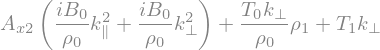

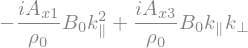

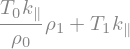

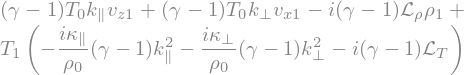

In [74]:
energy_nad = energy.subs(substitutions)

display(cont_simple)
display(mom1_simple)
display(mom2_simple)
display(mom3_simple)
display(energy_nad)
display(induction1_simple)
display(induction2_simple)
display(induction3_simple)

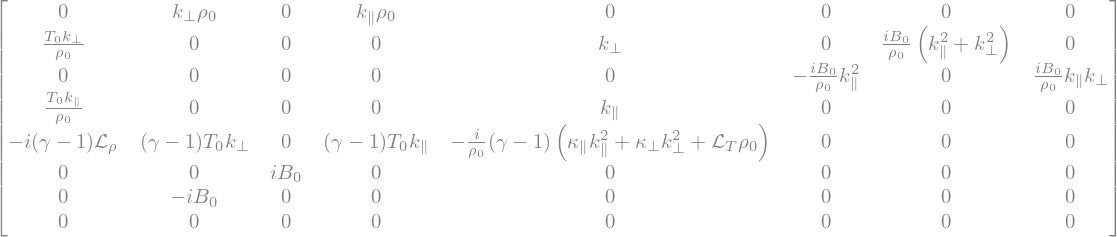

In [75]:
nad_matrix = sp.Matrix([
  [0, k_perp * rho0, 0, k_para * rho0, 0, 0, 0, 0],
  [T0 * k_perp / rho0, 0, 0, 0, k_perp, 0, sp.I * b0 / rho0 * (k_para**2+k_perp**2), 0],
  [0, 0, 0, 0, 0, -sp.I * b0 * k_para**2 / rho0, 0, sp.I * b0 * k_para * k_perp / rho0],
  [T0 * k_para / rho0, 0, 0, 0, k_para, 0, 0, 0],
  [
    -sp.I * gmone * Lrho, 
    gmone * T0 * k_perp, 
    0, 
    gmone * T0 * k_para, 
    -sp.I * gmone * (
      kappa_para * k_para**2 + kappa_perp * k_perp**2 + rho0 * LT
    ) / rho0, 
    0, 
    0, 
    0
  ],
  [0, 0, sp.I * b0, 0, 0, 0, 0, 0],
  [0, -sp.I * b0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0]
])
display(nad_matrix)